In [119]:
from random import random
from random import randint
from random import choice
from numpy import array
from numpy import zeros
import numpy as np
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [80]:
def check_in_frame ( size, pos ):
    """
    Allow space around the shape
    """
    if 0 <= pos[0] < size and  0 <= pos[1] < size:
        return True
    return False

def check_in_frame_with_space ( size, pos ):
    """
    Allow space around the shape
    """
    if 1 <= pos[0] < size - 1 and  1 <= pos[1] < size - 1:
        return True
    return False

def generate_u_shape ( frame, bottom, left, right, direction, position ):
    """
    Impose an U shape structure on the frame, position is where you start it (top-left corner of rectangle)
    
    This is an U-shape with bottom = 4, left = 4, right = 3, direction = 0
    S
    o x x o
    o x x o
    o o o o
    
    S o o o 
    o x x 
    o x x 
    o o o
    
    S o o o
    o x x o
    o x x o
    o 
    
    # Let consider this case in a later phase
    This is an U-shape with bottom = 4, left = 4, right = 3, direction = 1
    
            o
          o
        o x
      o x x x
        o x x x o
          o x o
            o
    We can start with even direction first ( 0 (North), 2 (East), 4 (South), 6(West) )
    The positions marked with x are the positions that are considered inside the U-shape
    
    This function returns whether imposition successes, and frame would be imposed with the U-shape
    
    Parameters:
    =====================
    frame: squared frame
    bottom: integer value
    left: integer value
    right: integer value
    direction: 
    position: tuple of 2
    
    Returns:
    =====================
    - success: whether imposition successes or not
    - inside_points: list of points inside the shape (x)
    
    """
    size = frame.shape[0]
    
    if direction == 0 or direction == 4:
        other_corner = ( position[0] + max(left, right) - 1, position[1] + bottom - 1 )
        
    if direction == 2 or direction == 6:
        other_corner = ( position[0] + bottom - 1, position[1] + max(left, right) - 1 )

    if not check_in_frame_with_space ( size, position) or not check_in_frame_with_space ( size, other_corner ):
        return False, ( [], [] )
    
    # Let's create one U-shape that has a direction == 0, than we rotate it
    inner_shape = np.zeros((max(left, right), bottom))
    # Left side
    for i in range (max(left, right)):
        inner_shape[i,0] = 1
    
    # Right side
    for i in range (max(left, right) - min(left, right), max(left, right)):
        inner_shape[i,bottom - 1] = 1
    
    # Bottom side
    for i in range (bottom):
        inner_shape[max(left, right) - 1,i] = 1
        
    for i in range(max(left, right) - min(left, right), max(left, right) - 1):
        for j in range(1, bottom - 1):
            inner_shape[i,j] = 2
    
    rotated_shape = np.rot90 ( inner_shape, -direction // 2 )
    
    
    frame[ position[0] : position[0] + rotated_shape.shape[0], 
          position[1] : position[1] + rotated_shape.shape[1] ] = rotated_shape
    
    inside_points = np.where(frame == 2)
    
    frame[frame == 2] = 0
    
    return True, inside_points


In [66]:
def check_in_range (value, bottom, left, right, direction, position ):
    """
    bottom, left, right, direction, position is the parameters of U-shape
    
    value is a coordinates (x, y)
    """
    if direction == 0 or direction == 4:
        if position[0] <= value[0] <= position[0] + max(left, right) and position[1] <= value[1] <= position[1] + bottom:
            return True
    
    if direction == 2 or direction == 6:
        if position[0] <= value[0] <= position[0] + bottom and position[1] <= value[1] <= position[1] +  max(left, right):
            return True
    
    return False

In [55]:
a = np.ones((2,3))
np.where(a == 1)

(array([0, 0, 0, 1, 1, 1], dtype=int64),
 array([0, 1, 2, 0, 1, 2], dtype=int64))

In [58]:
f = zeros ((10, 10))
generate_u_shape (f , 4, 4, 3, 4, (5,4) )

(True, (array([6, 6, 7, 7], dtype=int64), array([5, 6, 5, 6], dtype=int64)))

In [59]:
f

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [128]:
def generate_env ( size, bottom_range = list(range(3,5)), 
                  left_range = list(range(3,5)), right_range = list(range(3,5)), 
                  direction_range = list(range(0,8,2)) ):
    frame = zeros((size,size))
    
    # You random a value in those range to add into the frame
    # You also
    bottom = choice(bottom_range)
    left = choice(left_range)
    right = choice(right_range)
    direction = choice(direction_range)
    while True:
        position_x = randint ( 0, size - 1 )
        position_y = randint ( 0, size - 1 )
        position = (position_x, position_y)

        success, inner_list = generate_u_shape  ( frame, bottom, left, right, direction, position )
        
        if success : 
            break
    
    # Random outer position for moving point
    while True:
        pos_start_x = randint ( 0, size - 1 )
        pos_start_y = randint ( 0, size - 1 )
        
        pos_start = (pos_start_x, pos_start_y)
        
        # Just need to be out of the rectangle
        if check_in_range ( pos_start, bottom, left, right, direction, position ):
            continue
            
        break
    
    # Random inner position for moving point
    index = randint ( 0, len(inner_list[0]) - 1 )
    pos_end = (inner_list[0][index], inner_list[1][index])
    
    return frame, pos_start, pos_end

In [129]:
frame, pos_start, pos_end = generate_env ( 10 )

In [130]:
frame

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [131]:
pos_start

(7, 9)

In [135]:
pos_end

(4, 4)

In [138]:
def get_neighbors ( size, pos ):
    neighbors = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (i == 0 or j == 0) and not i == j == 0:
                new_pos = (pos[0] + i, pos[1] + j)
                if check_in_frame ( size, new_pos ):
                    neighbors.append(new_pos)
    return neighbors
    

def generate_path ( frame, pos_start, pos_end ):
    size = frame.shape[0]
    # Keep track of the previous cell that has been expanded to
    parent = {}
    
    ### There is nothing too difficult here, we run overflow algorithm to cover the space
    f = frame.copy()
    f[pos_start] = 2
    f[pos_end] = 3
    
    explore_list = [ pos_start ]
    
    def search ( l ):
        while l:
            # Get the shortest path to the pos_end
            new_explore_list = []

            for pos in l:
                for n in get_neighbors( size, pos ):
                    if f[n] == 3:
                        # Found
                        parent[n] = pos
                        return
                    if f[n] == 0:
                        # Add into new list
                        new_explore_list.append(n)
                        parent[n] = pos
                        # 4 is marked
                        f[n] = 4
            l = new_explore_list
        
    
    search ( explore_list )
    cur = pos_end
    
    path = []
    while cur in parent:
        path.append(cur)
        cur = parent[cur]
    
    path.append(cur)
    return path[::-1]

In [139]:
generate_path ( frame, pos_start, pos_end )

[(7, 9), (6, 9), (5, 9), (4, 9), (4, 8), (4, 7), (4, 6), (4, 5), (4, 4)]

In [146]:
def build_frames(size):
    frames = list()
    # create the first frame
    frame, pos_start, pos_end = generate_env ( size )
    
    # If it is enter (enter = 1): start with pos_start, end with pos_end
    # If it is exit (exit = 1): start with pos_end, end with pos_start
    enter = 1 if random() < 0.5 else 0
    
    if enter == 0:
        pos_start, pos_end = (pos_end, pos_start)
        
    path = generate_path ( frame, pos_start, pos_end )
    
    for step in path:
        f = frame.copy()
        f[step] = 1
        frames.append(f)
        
    return frames, enter

In [147]:
from matplotlib import pyplot

ValueError: num must be 1 <= num <= 10, not 11

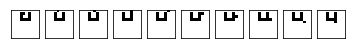

In [150]:
size = 10
frames, enter = build_frames(size)
# plot all frames
pyplot.figure()
for i in range(len(frames)):
    # create a gray scale subplot for each frame
    pyplot.subplot(1, size, i + 1)
    pyplot.imshow(frames[i], cmap='Greys')
    # turn of the scale to make it clearer
    ax = pyplot.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# show the plot
pyplot.show()